# Coin Counter

In [212]:
from fastai.vision.all import *

## Load Data

In [91]:
path = Path("/home/jupyter/coin-counter/data/"); path.ls()

(#8) [Path('/home/jupyter/coin-counter/data/1'),Path('/home/jupyter/coin-counter/data/coin-data.xlsx'),Path('/home/jupyter/coin-counter/data/.ipynb_checkpoints'),Path('/home/jupyter/coin-counter/data/Coin-data-20201017T182440Z-001.zip'),Path('/home/jupyter/coin-counter/data/3'),Path('/home/jupyter/coin-counter/data/Coin-data'),Path('/home/jupyter/coin-counter/data/2'),Path('/home/jupyter/coin-counter/data/0')]

In [99]:
df = pd.read_excel(path/"coin-data.xlsx", sheet_name=[0, 1, 3])
dfs = [list(df.items())[i][1] for i in range(len(df))]
df = pd.concat(dfs); df

,Quarters,Dimes,Nickels,Pennies
0,1,0,1,1
1,1,0,1,1
2,1,0,1,1
3,1,0,1,1
4,1,0,1,1
...,...,...,...,...
49,3,2,1,2
50,3,2,1,2
51,3,2,1,2
52,3,2,1,2


In [100]:
imgs = get_files(path, extensions=['.JPG']); imgs.sort(); imgs

(#123) [Path('/home/jupyter/coin-counter/data/0/IMG_5517.JPG'),Path('/home/jupyter/coin-counter/data/0/IMG_5518.JPG'),Path('/home/jupyter/coin-counter/data/0/IMG_5519.JPG'),Path('/home/jupyter/coin-counter/data/0/IMG_5520.JPG'),Path('/home/jupyter/coin-counter/data/0/IMG_5521.JPG'),Path('/home/jupyter/coin-counter/data/0/IMG_5522.JPG'),Path('/home/jupyter/coin-counter/data/0/IMG_5523.JPG'),Path('/home/jupyter/coin-counter/data/0/IMG_5524.JPG'),Path('/home/jupyter/coin-counter/data/0/IMG_5525.JPG'),Path('/home/jupyter/coin-counter/data/0/IMG_5526.JPG')...]

In [101]:
df["image"] = imgs
df = df.reset_index(drop=True); df

,Quarters,Dimes,Nickels,Pennies,image
0,1,0,1,1,/home/jupyter/coin-counter/data/0/IMG_5517.JPG
1,1,0,1,1,/home/jupyter/coin-counter/data/0/IMG_5518.JPG
2,1,0,1,1,/home/jupyter/coin-counter/data/0/IMG_5519.JPG
3,1,0,1,1,/home/jupyter/coin-counter/data/0/IMG_5520.JPG
4,1,0,1,1,/home/jupyter/coin-counter/data/0/IMG_5521.JPG
...,...,...,...,...,...
118,3,2,1,2,/home/jupyter/coin-counter/data/3/IMG_5890.JPG
119,3,2,1,2,/home/jupyter/coin-counter/data/3/IMG_5891.JPG
120,3,2,1,2,/home/jupyter/coin-counter/data/3/IMG_5892.JPG
121,3,2,1,2,/home/jupyter/coin-counter/data/3/IMG_5893.JPG


## Process Data

In [118]:
PILImage.create(imgs[0]).shape

(2448, 3264)

In [248]:
data = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=4)),
                get_x=ColReader('image'), 
                 get_y=ColReader(cols=["Quarters", "Dimes", "Nickels", "Pennies"]),
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                n_inp=1, item_tfms=Resize((249, 326)), batch_tfms=aug_transforms(flip_vert=True))

In [249]:
dls = data.dataloaders(df, bs=32); len(dls.train_ds), len(dls.valid_ds), len(dls.train), len(dls.valid)

(99, 24, 3, 1)

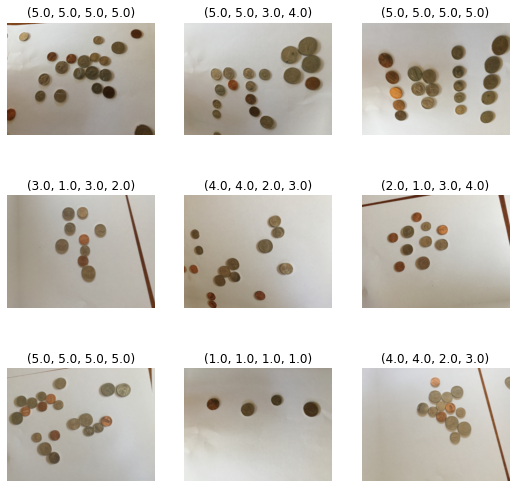

In [163]:
dls.show_batch()

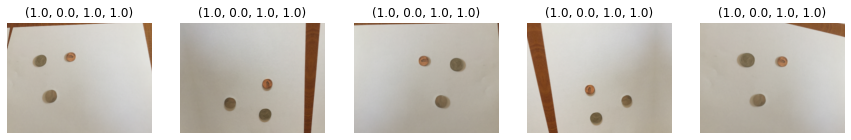

In [164]:
dls.show_batch(unique=True, max_n=5, nrows=1)

In [165]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([32, 3, 249, 326]), torch.Size([32, 4]))

## Create Model

In [193]:
learn = cnn_learner(dls, resnet18, y_range=[0, 5])

## Train Model

In [ ]:
learn.lr_find()

In [195]:
lr = 3e-3

In [196]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,time
0,3.713662,7.045100,00:10
1,3.037559,5.281114,00:10
2,2.756495,3.274067,00:10
3,2.606770,2.650058,00:10
4,2.510007,2.602312,00:10
5,2.425767,2.504208,00:10
6,2.371336,2.300560,00:10
7,2.311969,2.095172,00:10
8,2.288168,2.062088,00:10
9,2.249382,2.046174,00:10


In [197]:
learn.unfreeze()
learn.fit(10, slice(lr/100, lr/10))

epoch,train_loss,valid_loss,time
0,1.936625,2.103032,00:10
1,1.888543,1.845296,00:10
2,1.837846,1.590257,00:10
3,1.835563,1.799235,00:10
4,1.825182,2.048181,00:10
5,1.836726,2.363434,00:10
6,1.801367,2.539194,00:10
7,1.787113,2.602117,00:10
8,1.759019,2.398788,00:10
9,1.736162,2.120180,00:10


## Analyze Results

In [244]:
interp = Interpretation.from_learner(learn)

In [247]:
interp.top_losses()

torch.return_types.topk(
values=tensor([7.8261e+00, 4.3926e+00, 4.3561e+00, 3.3792e+00, 3.3481e+00, 3.0950e+00,
        2.8724e+00, 2.1660e+00, 2.1555e+00, 1.9989e+00, 1.9253e+00, 1.9213e+00,
        1.6062e+00, 1.4986e+00, 1.4370e+00, 1.3354e+00, 1.2453e+00, 1.1168e+00,
        9.9546e-01, 9.6412e-01, 7.1477e-01, 5.3416e-01, 1.2702e-05, 6.4023e-07]),
indices=tensor([13, 19, 21, 20, 14, 15,  8,  9,  3,  4, 23,  5, 18,  1, 10, 16, 12, 22,
         7, 11,  0, 17,  6,  2]))

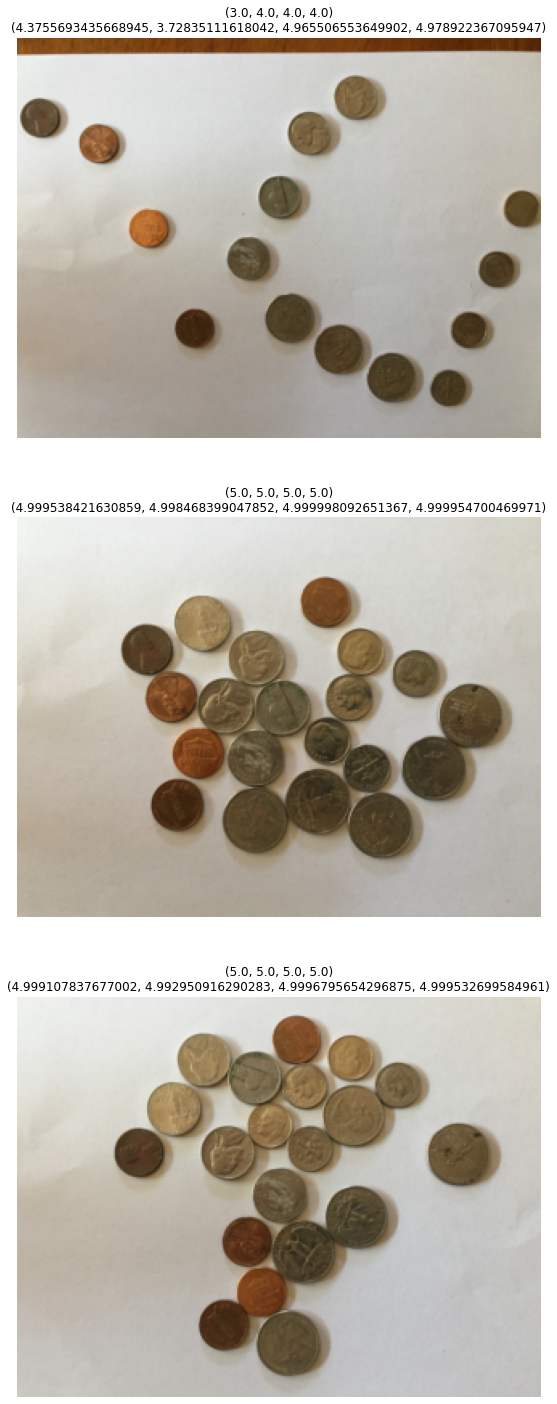

In [198]:
learn.show_results(max_n=3, nrows=3, figsize=(20, 25))

### Compare Against Random Baseline

## Create Post-Processing Function

In [208]:
_, _, preds = learn.predict(imgs[0]); preds

tensor([0.0144, 0.0003, 0.0281, 0.0289])

In [214]:
np.rint(preds)

tensor([0., 0., 0., 0.])

In [225]:
dict(zip(['Q', 'D'], preds[:2].tolist()))

{'Q': 0.014434576965868473, 'D': 0.00027931242948397994}

In [230]:
def post_process(preds):
    """Converts raw predictions into coin counts and total."""
    coin_counts = dict(zip(["quarter", "dimes", "nickels", "pennies"], np.round(preds).tolist()))
    return coin_counts, sum(coin_counts.values())

In [231]:
post_process(preds)

({'quarter': 0.0, 'dimes': 0.0, 'nickels': 0.0, 'pennies': 0.0}, 0.0)

In [239]:
def infer(fn):
    img = PILImage.create(fn)
    img.show()
    _, _, preds = learn.predict(img)
    return img, post_process(preds)

(PILImage mode=RGB size=3264x2448,
 ({'quarter': 2.0, 'dimes': 0.0, 'nickels': 0.0, 'pennies': 0.0}, 2.0))

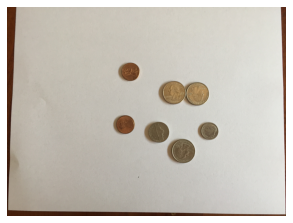

In [243]:
infer(imgs[100])

## Test on Own Image